# Clustering Crypto

In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

### Fetching Cryptocurrency Data

In [6]:
url = "https://min-api.cryptocompare.com/data/all/coinlist"
response_data = requests.get(url).json()

In [7]:
# Creating a DataFrame
from pathlib import Path
file_path = Path("Resources/crypto_data.csv")
crypto_df = pd.read_csv(file_path, index_col='Unnamed: 0')
crypto_df.head(10)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
2015,2015 coin,X11,True,PoW/PoS,NaN,0
BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,True,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,True,PoW,6.303924e+07,84000000


In [144]:
crypto_df.shape

(1252, 6)

### Data Preprocessing

In [145]:
# Traspose the data
crypto_df.dtypes

CoinName            object
Algorithm           object
IsTrading             bool
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply     object
dtype: object

In [146]:
# Remove unnecessary columns / Remove null columns
crypto_df = crypto_df.dropna(axis='rows')
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000


In [147]:
crypto_df.shape

(744, 6)

In [148]:
# Keep only cryptocurrencies that are on trading
crypto_df.drop(crypto_df[crypto_df['IsTrading'] == False].index, inplace=True)

In [149]:
# Removing rows with cryptocurrencies without coins mined
crypto_df.drop(crypto_df[crypto_df['TotalCoinsMined'] == 0].index, inplace=True)

In [150]:
# Remove the "IsTrading" column
crypto_df.drop('IsTrading', axis=1, inplace=True)

In [151]:
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0


In [152]:
# Removing rows with at least 1 null value
crypto_df.dropna(inplace=True)

In [153]:
# Dropping rows where there are 'N/A' text values

In [154]:
# Fetching the cryptocurrencies names prior to drop them from crypto_df
coin_names = crypto_df.copy()
coin_names = pd.DataFrame(crypto_df['CoinName'], index=crypto_df.index)
coin_names.head()


,CoinName
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum


In [155]:
# Removig the cryptocurrency name since it's not going to be used on the clustering algorithm
crypto_df = crypto_df.drop('CoinName', axis=1)


In [156]:
crypto_df.shape

(533, 4)

In [157]:
crypto_df.tail()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
ZEPH,SHA-256,DPoS,2.000000e+09,2000000000
GAP,Scrypt,PoW/PoS,1.493105e+07,250000000
BDX,CryptoNight,PoW,9.802226e+08,1400222610
ZEN,Equihash,PoW,7.296538e+06,21000000
XBC,Scrypt,PoS,1.283270e+05,1000000


In [158]:
# Creating dummies variables for text features
crypto_df_dummies = pd.get_dummies(crypto_df, columns=['Algorithm', 'ProofType'])
crypto_df_dummies.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:
# Standardizing data
crypto_scaler = StandardScaler().fit_transform(crypto_df_dummies)

### Reducing Dimensions Using PCA

In [160]:
# Using PCA to reduce dimension to 3 principal components

pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(crypto_scaler)


In [161]:
# Creating a DataFrame with the principal components data
df_crypto_pca = pd.DataFrame(data=crypto_pca, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'],
                            index=crypto_df.index)
df_crypto_pca.head()

,Principal Component 1,Principal Component 2,Principal Component 3
42,-0.339167,1.073742,-0.617595
404,-0.322481,1.073659,-0.617915
1337,2.331904,1.597576,-0.674814
BTC,-0.138890,-1.320793,0.229412
ETH,-0.147125,-2.072726,0.405291


### Clustering Crytocurrencies Using K-Means

#### Finding the Best Value for `k` Using the Elbow Curve

In [162]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range ok k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_crypto_pca)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")


:Curve   [k]   (inertia)

Running K-Means with `k=<you best value for k here>`

In [163]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(df_crypto_pca)

# Predict clusters
predictions = model.predict(df_crypto_pca)

# Creating a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pd.concat([crypto_df, df_crypto_pca], axis=1)
clustered_df["Class"] = model.labels_
clustered_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,Principal Component 1,Principal Component 2,Principal Component 3,Class
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.339167,1.073742,-0.617595,0
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.322481,1.073659,-0.617915,0
1337,X13,PoW/PoS,2.927942e+10,314159265359,2.331904,1.597576,-0.674814,0
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.138890,-1.320793,0.229412,1
ETH,Ethash,PoW,1.076842e+08,0,-0.147125,-2.072726,0.405291,1


### Visualizing Results

#### 3D-Scatter with Clusters

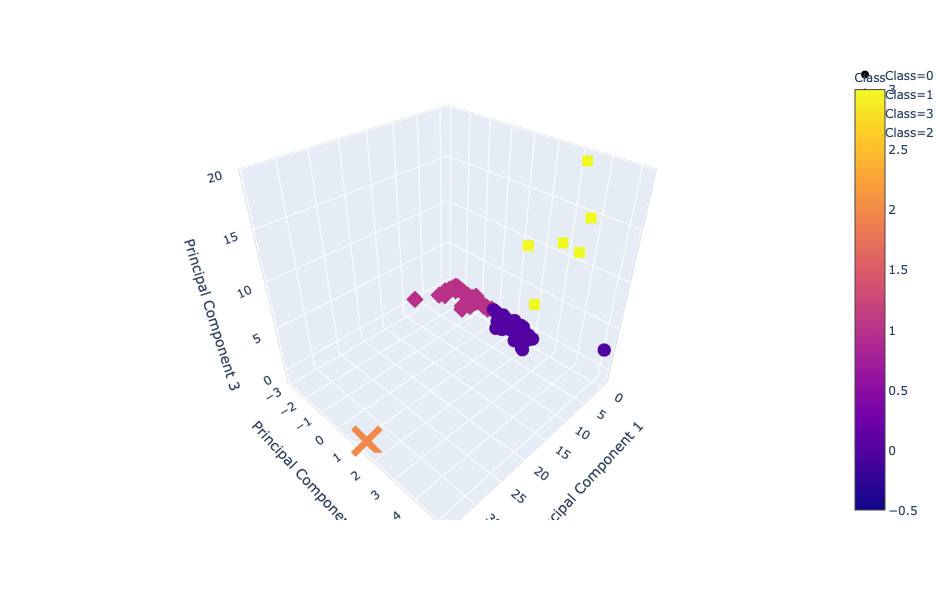

In [164]:
# Creating a 3D-Scatter  with the PCA data and the clusters
plot= px.scatter_3d(clustered_df,
    x="Principal Component 1",
    y="Principal Component 2",
    z="Principal Component 3",
    symbol="Class",
    color="Class",
    width=800
)
plot.show()

#### Table of Tradable Cryptocurrencies

In [165]:
# Table with tradable cryptos

clustered_df[["Algorithm", "ProofType", "TotalCoinSupply", "TotalCoinsMined", "Class",]
    ].hvplot.table()

:Table   [Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

#### Scatter Plot with Tradable Cryptocurrencies

In [166]:
# Scaling data to create the scatter plot

scaled_df = clustered_df.copy()
scaled_cols = ['TotalCoinsMined', 'TotalCoinSupply']
features = scaled_features[scaled_cols]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_df[scaled_cols] = features
scaled_df.head()


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,Principal Component 1,Principal Component 2,Principal Component 3,Class
42,Scrypt,PoW/PoS,0.005942,4.200000e-11,-0.339167,1.073742,-0.617595,0
404,Scrypt,PoW/PoS,0.007002,5.320000e-04,-0.322481,1.073659,-0.617915,0
1337,X13,PoW/PoS,0.035342,3.141593e-01,2.331904,1.597576,-0.674814,0
BTC,SHA-256,PoW,0.005960,2.100000e-05,-0.138890,-1.320793,0.229412,1
ETH,Ethash,PoW,0.006050,0.000000e+00,-0.147125,-2.072726,0.405291,1


In [169]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
scaled_df.hvplot.scatter(
    x="TotalCoinsMined",
    y="TotalCoinSupply",
    hover_cols=["Class"],
    by="Class",
)



:NdOverlay   [Class]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,Class)